# Setup

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import dill as pickle
import time

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [259]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/b1101_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.022675,0.000449,2.186692
control__wt_glc__2,-0.022675,-0.000449,2.369230
fur__wt_dpd__1,-0.963452,0.008769,0.490542
fur__wt_dpd__2,-1.105777,0.010157,0.492320
fur__wt_fe__1,0.041365,-0.006997,1.756930


# Create Grids for Each Condition

In [260]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [261]:
# NOTE: Check that this equation is the one you want
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [262]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

## Individual Grid

In [6]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,100],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

## Combined Grid

In [263]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

cAct_range = {'cActivator': [0,2]} # Use a log10 range
cInh_range = {'cInhibitor': [-1,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
    
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

### cAct and cInh Grid Histograms

Text(0.5, 0.98, 'Condition: control__wt_glc__1')

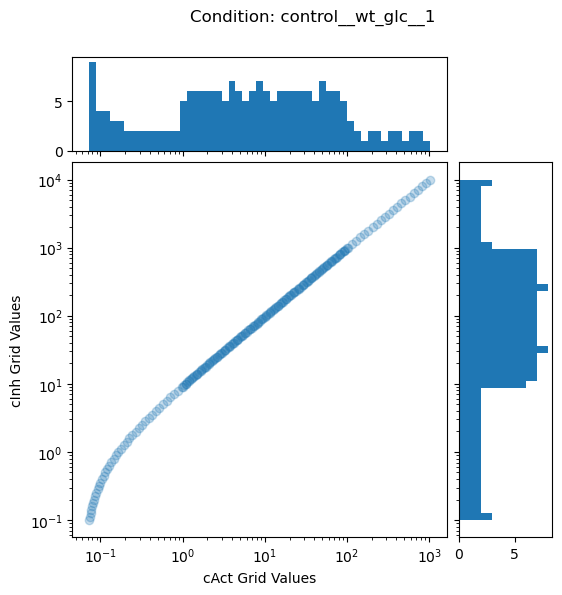

In [264]:
i = 0

x = [cAct for (cAct, _) in grid.iloc[i,1]]
y = [cInh for (_, cInh) in grid.iloc[i,1]]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x, y, alpha=0.25)

x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)

ax_histx.hist(x, bins=x_bins)
ax_histy.hist(y, bins=y_bins, orientation='horizontal')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cAct Grid Values')
ax.set_ylabel('cInh Grid Values')

fig.suptitle('Condition: '+str(grid.index[i]))

In [265]:
grid

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.07390374033635091, 0.1), (0.07515356672096..."
control__wt_glc__2,2.369230,"[(0.0884301336265355, 0.1), (0.089846416823985..."
fur__wt_dpd__1,0.490542,"[(0.0011348626582396613, 1.2589254117941675), ..."
fur__wt_dpd__2,0.492320,"[(0.001277544681404343, 1.2589254117941675), (..."
fur__wt_fe__1,1.756930,"[(0.044264401834296155, 0.1), (0.0451745933403..."
...,...,...
efeU__menFentCubiC_ale36__2,2.094938,"[(0.06707281936364254, 0.1), (0.06824437075520..."
efeU__menFentCubiC_ale37__1,1.738910,"[(0.0431423604050855, 0.1), (0.044039694525481..."
efeU__menFentCubiC_ale37__2,1.679786,"[(0.03952173290395265, 0.1), (0.04037757853493..."
efeU__menFentCubiC_ale38__1,1.813270,"[(0.04783002303562685, 0.1), (0.04878107271814..."


# DEAP

In [266]:
# Set reproducible random seed
seed = 42
rng = np.random.default_rng(seed=seed)

In [267]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (len(grid),), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

toolbox = base.Toolbox()

def generate_individual(individual_class: type, grid: pd.Series):
    '''
    Randomly pick tuples from each condition's grid to create an individual
    
    :param type individual_class: Class that the individual will inherit from
    :param pd.Series grid: Contains the parameter grids for each condition
    '''
    individual = np.empty(shape=individual_class.shape, dtype=individual_class.dtype)

    for i, condition in enumerate(grid):
        individual[i] = tuple(rng.choice(a=condition, size=1, replace=False)[0])
        
    return individual_class(individual)

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [268]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    # Create arrays with the ordered condition parameters
    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']

    ind_activator = individual['act']
    ind_inhibitor = individual['inh']
    
    # Calculate the spearman rank coefficient
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate',
                function = spearman_objective,
                MA_df = MA_df)

In [269]:
toolbox.register("select", tools.selNSGA2, nd='log') # I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

In [270]:
# Mutation
def mutate(individual: object, prob: float, grid: pd.Series):
    # Iterate over all conditions if an individual is selected to mutate
    for i, _ in enumerate(individual):
        if rng.random() < prob:
            # Select a new set of parameters for a condition from the grid
            # Requires the "grid" to be in a specific location of the dataframe
            individual[i] = tuple(rng.choice(a=grid.iloc[i], size=1, replace=False)[0])

    return individual

mt_prob = 0.1  # NOTE: These values were chosen based on brute_force.ipynb
toolbox.register('mutate', function = mutate, prob = mt_prob, grid = grid.grid)

In [271]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):
    # Individuals are already deep-copied before going into this function
    for i, _ in enumerate(ind_one):
        if rng.random() < prob:
            # Use copies to avoid modifying the np.array in place
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.6 # NOTE: These values were chosen based on brute_force.ipynb

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [272]:
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],ind.fitness.values[1]))

In [273]:
def best_individual(population: list):
    """
    Returns a list containing the total scores for each individual and a list 
    containining the np.argsort indices for the ascending sorted scores

    :param list population: List of individuals with fitness scores
    """
    a, b = zip(*[population[i].fitness.values for i in range(len(population))])
    total_scores = np.subtract(a,b) # Since objective weights are (1.0, -1.0)
    sorted_index = np.argsort(total_scores)

    return total_scores, sorted_index

In [274]:
# Copied directly from DEAP, update to use np.random
def var_Or(population, toolbox, lambda_, cxpb, mutpb):
    r"""Part of an evolutionary algorithm applying only the variation part
    (crossover, mutation **or** reproduction). The modified individuals have
    their fitness invalidated. The individuals are cloned so returned
    population is independent of the input population.

    :param population: A list of individuals to vary.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param lambda\_: The number of children to produce
    :param cxpb: The probability of mating two individuals.
    :param mutpb: The probability of mutating an individual.
    :returns: The final population.

    The variation goes as follow. On each of the *lambda_* iteration, it
    selects one of the three operations; crossover, mutation or reproduction.
    In the case of a crossover, two individuals are selected at random from
    the parental population :math:`P_\mathrm{p}`, those individuals are cloned
    using the :meth:`toolbox.clone` method and then mated using the
    :meth:`toolbox.mate` method. Only the first child is appended to the
    offspring population :math:`P_\mathrm{o}`, the second child is discarded.
    In the case of a mutation, one individual is selected at random from
    :math:`P_\mathrm{p}`, it is cloned and then mutated using using the
    :meth:`toolbox.mutate` method. The resulting mutant is appended to
    :math:`P_\mathrm{o}`. In the case of a reproduction, one individual is
    selected at random from :math:`P_\mathrm{p}`, cloned and appended to
    :math:`P_\mathrm{o}`.

    This variation is named *Or* because an offspring will never result from
    both operations crossover and mutation. The sum of both probabilities
    shall be in :math:`[0, 1]`, the reproduction probability is
    1 - *cxpb* - *mutpb*.
    """

    assert (cxpb + mutpb) <= 1.0, (
        "The sum of the crossover and mutation probabilities must be smaller "
        "or equal to 1.0.")

    offspring = []
    for _ in range(lambda_):
        op_choice = rng.random()
        if op_choice < cxpb:
            # Apply crossover
            # Use rng.choice with arange to get a random integer and copy that individual, rather than generate an np.array and create an individual from that
            ind1, ind2 = [toolbox.clone(population[i]) for i in rng.choice(a=np.arange(start=0, stop=len(population), step=1), size=2, replace=False)]
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1) # We currently only take one of the crossover indidivuals
        elif op_choice < cxpb + mutpb:
            # Apply mutation
            ind = toolbox.clone(population[rng.choice(a=np.arange(start=0, stop=len(population), step=1), size=1, replace=False)[0]])
            ind = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:
            # Apply reproduction
            offspring.append(rng.choice(a=population, size=1, replace=False))

    return offspring

In [275]:
def mu_plus_lambda(population = list,
                   toolbox = base.Toolbox(),
                   mu = int,
                   lambda_ = int,
                   cxpb = float,
                   mutpb = float,
                   n_gen = int,
                   n_iter = int,
                   grid = pd.Series,
                   stats = None,
                   hall_of_fame = None,
                   verbose = __debug__):
    """
    Modified DEAP mu+lambda evolutionary algorithm using varOr

    :param list population: List of individuals to serve as the starting population
    :param base.Toolbox() toolbox: DEAP class containing evolution operators
    :param int mu: Number of individuals to select for the next generation
    :param int lambda_: Number of children to produce at each generation
    :param float cxpb: Probability that an offspring is produced by crossover
    :param float mutpb: Probability that an offspring is produced by mutation
    :param int n_gen: Number of generations to run
    :param int n_iter: Greedy offspring population size
    :param pd.Series grid: Series containing grids for each condition
    :param stats: DEAP class containing the types of statistics to record in the logbook
    :param halloffame: DEAP class containing the best individuals evaluated
    :param verbose: Whether or not to print statistics for each generation
    :returns list pop: Final population
    :returns logbook: DEAP class containing stats for every generation

    evaluate(population)
    for g in range(ngen):
        offspring = varOr(population, toolbox, lamda_, cxpb, mutpb)
        evaluate(offspring)
        gradient_offspring = create_gradient_offspring(hof[0], toolbox)
        evaluate(gradient_offspring)
        population = select(population+offspring+gradient_offspring, mu)
    """

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals', 'best'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if hall_of_fame is not None:
        hall_of_fame.update(population)

    total_scores, sorted_index = best_individual(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, n_gen + 1):
        # Vary the population
        offspring = var_Or(population, toolbox, lambda_, cxpb, mutpb)

        # Greedy offspring
        if gen % 100 == 0:
            greedy_offspring, _ = create_greedy_offspring(population[sorted_index[-1]], n_iter, grid)
            offspring = offspring+greedy_offspring

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        # NOTE: I feel like HoF should update after the next population is created? That way we only have to compare max mu individuals to the HoF?
        if hall_of_fame is not None:
            hall_of_fame.update(offspring)

        # Manually ensure elitism
        population = population + offspring
        _, temp_sorted = best_individual(population)
        hof_individual = population[temp_sorted[-1]]

        # Select the next generation population
        population[:] = toolbox.select(population, mu)
        population.append(hof_individual)

        # Update the statistics with the new population
        total_scores, sorted_index = best_individual(population)

        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [276]:
nind = 100
mu = 100
lambda_ = 100
cxpb = 1
mutpb = 0
n_gen = 1000
n_iter = 0

pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=True)

gen	nevals	best    
0  	100   	0.139005
1  	100   	0.197853
2  	100   	0.197853
3  	100   	0.239892
4  	100   	0.299184
5  	100   	0.299184
6  	100   	0.299184
7  	100   	0.299184
8  	100   	0.36194 
9  	100   	0.376455
10 	100   	0.443238
11 	100   	0.451616
12 	100   	0.453362
13 	100   	0.514906
14 	100   	0.523326
15 	100   	0.555393
16 	100   	0.628967
17 	100   	0.635921
18 	100   	0.650433
19 	100   	0.689365
20 	100   	0.691719
21 	100   	0.758037
22 	100   	0.758037
23 	100   	0.761276
24 	100   	0.799765
25 	100   	0.803555
26 	100   	0.850052
27 	100   	0.850052
28 	100   	0.850052
29 	100   	0.854985
30 	100   	0.856294
31 	100   	0.888987
32 	100   	0.888987
33 	100   	0.898443
34 	100   	0.903777
35 	100   	0.916264
36 	100   	0.936936
37 	100   	0.936936
38 	100   	0.952987
39 	100   	0.960631
40 	100   	0.969304
41 	100   	0.973648
42 	100   	0.987165
43 	100   	0.992834
44 	100   	1.00736 
45 	100   	1.01056 
46 	100   	1.0154  
47 	100   	1.0154  
48 	100   	1.02139 


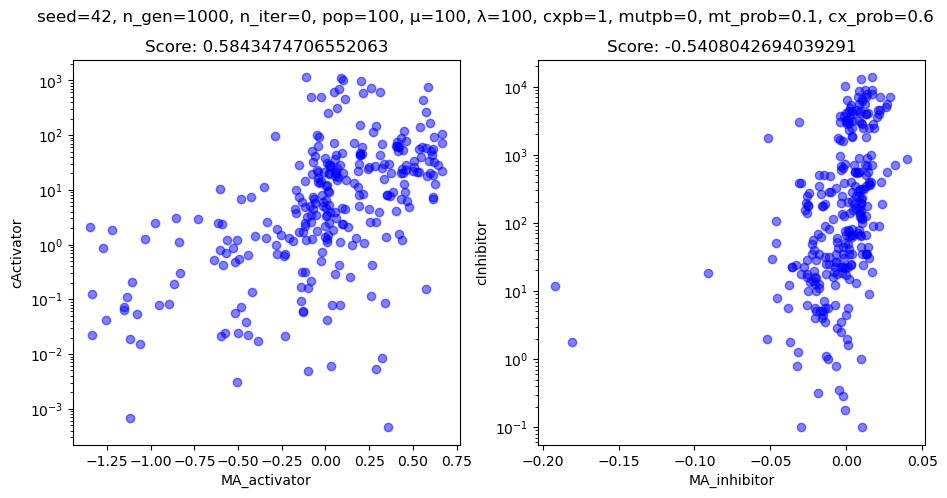

In [277]:
total_score, total_sort = best_individual(pop)
scatter_individual(pop[total_sort[-1]])

In [278]:
# Save the output as a pickle for Chris
path = '/Users/gchhughes/Github/regulonML/data/act_inh_pkl/'
filename = '231003-b1101.pkl' # NOTE: Update me!

# Stuff for the pickle object
cAct = list(pop[total_sort[-1]]['act'])
cInh = list(pop[total_sort[-1]]['inh'])
index = list(grid.index)
act_inh_scores = pop[total_sort[-1]].fitness.values
constant_equation_vals = constant_vals.copy()
DEAP_vals = {'seed': seed,
             'n_gen': n_gen,
             'n_ind': nind,
             'n_iter': n_iter, # Not used, including for completeness
             'mu': mu,
             'lambda_': lambda_,
             'cx_ind': cxpb,
             'cx_gene': cx_prob,
             'mt_ind': mutpb,
             'mt_gene': mt_prob,}


pickle_object = [cAct, cInh, index, act_inh_scores, constant_equation_vals, DEAP_vals]

with open(file=path+filename, mode='wb') as file:
    pickle.dump(obj=pickle_object, file=file)

In [279]:
# Create modified_greedy individuals, and use the best one for Chris
greedy_pop = modified_greedy(pop[total_sort[-1]], 10, grid.grid) # NOTE: Greedy pop is used below, so be careful when running things
greedy_score, greedy_sort = best_individual(greedy_pop)

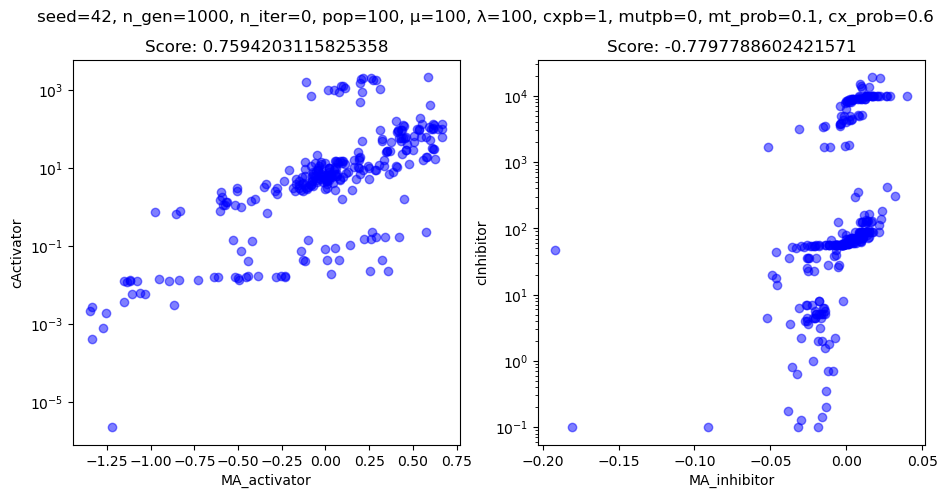

In [282]:
scatter_individual(greedy_pop[greedy_sort[-1]], )#pop[total_sort[-1]])

In [281]:
# Save the output as a pickle for Chris
path = '/Users/gchhughes/Github/regulonML/data/act_inh_pkl/'
filename = '231003-b1101-greedy.pkl' # NOTE: Update me!

# Stuff for the pickle object
cAct = list(greedy_pop[greedy_sort[-1]]['act'])
cInh = list(greedy_pop[greedy_sort[-1]]['inh'])
index = list(grid.index)
act_inh_scores = greedy_pop[greedy_sort[-1]].fitness.values
constant_equation_vals = constant_vals.copy()
DEAP_vals = {'seed': seed,
             'n_gen': n_gen,
             'n_ind': nind,
             'n_iter': 10, # Not used, including for completeness
             'mu': mu,
             'lambda_': lambda_,
             'cx_ind': cxpb,
             'cx_gene': cx_prob,
             'mt_ind': mutpb,
             'mt_gene': mt_prob,}


pickle_object = [cAct, cInh, index, act_inh_scores, constant_equation_vals, DEAP_vals]

with open(file=path+filename, mode='wb') as file:
    pickle.dump(obj=pickle_object, file=file)

In [239]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
nind = 100
mu = 100
lambda_ = 100
cxpb = 0.6
mutpb = 0.4
n_gen = 1000
n_iter = 0
path = '/Users/gchhughes/Github/regulonML/ptsG_model_generation/hyperparameter_optimization/'


for n_gen in [10,100]:
    start_time = time.time()

    pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=False)
    # pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

    end_time = time.time()
    elapsed_time = round(end_time-start_time, 2)
    filename = '__seed_'+str(seed)+'__gen_'+str(n_gen)+'__pop_'+str(nind)+'__mu_'+str(mu)+'__lambda_'+str(lambda_)+'__cxind_'+str(cxpb)+'__cxgene_'+str(cx_prob)+'__mtind_'+str(mutpb)+'__mtgene_'+str(mt_prob)
    print('Time: '+str(elapsed_time)+filename)

    with open(file=path+filename+'.pkl', mode='wb') as file:
        pickle.dump(obj=[grid, pop, logbook, elapsed_time], file=file)


Time: 6.44__seed_42__gen_10__pop_100__mu_100__lambda_100__cxind_0.7__cxgene_0.1__mtind_0.3__mtgene_1
Time: 49.75__seed_42__gen_100__pop_100__mu_100__lambda_100__cxind_0.7__cxgene_0.1__mtind_0.3__mtgene_1


In [245]:
with open(file=str(path+'__seed_42__gen_100__pop_100__mu_100__lambda_100__cxind_0.7__cxgene_0.1__mtind_0.3__mtgene_1.pkl'), mode='rb') as file:
    test_grid, test_pop, test_logbook, elapsed_time = pickle.load(file)

In [246]:
total_score, total_sort = best_individual(test_pop)
total_score[total_sort[-1]]

1.2315031989504193

## Visualizing GA results

In [92]:
total_score, total_sort = best_individual(pop)

In [93]:
total_score[total_sort[-1]]

1.5019762660346618

In [94]:
old_individual = pop[total_sort[-1]]

In [95]:
print(old_individual.fitness.values)
print(pop[total_sort[-1]].fitness.values)

(0.7469569172115633, -0.7550193488230985)
(0.7469569172115633, -0.7550193488230985)


In [228]:
def scatter_individual(ind_one: object, ind_two: object=None, MA: pd.DataFrame=MA_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), squeeze=True)
    title = 'seed='+str(seed)+', n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
    fig.suptitle(title)
    ax1.set_xlabel('MA_activator')
    ax2.set_xlabel('MA_inhibitor')
    ax1.set_ylabel('cActivator')
    ax2.set_ylabel('cInhibitor')
    ax1.set_yscale('log')
    ax2.set_yscale('log')

    ax1.set_title('Score: '+str(ind_one.fitness.values[0]))
    ax2.set_title('Score: '+str(ind_one.fitness.values[1]))

    ax1.scatter(MA.MA_activator, list(ind_one['act']), alpha=0.5, c='b')
    ax2.scatter(MA.MA_inhibitor, list(ind_one['inh']), alpha=0.5, c='b')

    if ind_two is not None:
        ax1.scatter(MA.MA_activator, list(ind_two['act']), alpha=0.5, c='r')
        ax2.scatter(MA.MA_inhibitor, list(ind_two['inh']), alpha=0.5, c='r')
        ax1.set_title('Blue Score: '+str(ind_one.fitness.values[0])+'\n Red Score: '+str(ind_two.fitness.values[1]), fontsize=8)
        ax2.set_title('Blue Score: '+str(ind_one.fitness.values[1])+'\n Red Score: '+str(ind_two.fitness.values[1]), fontsize=8)

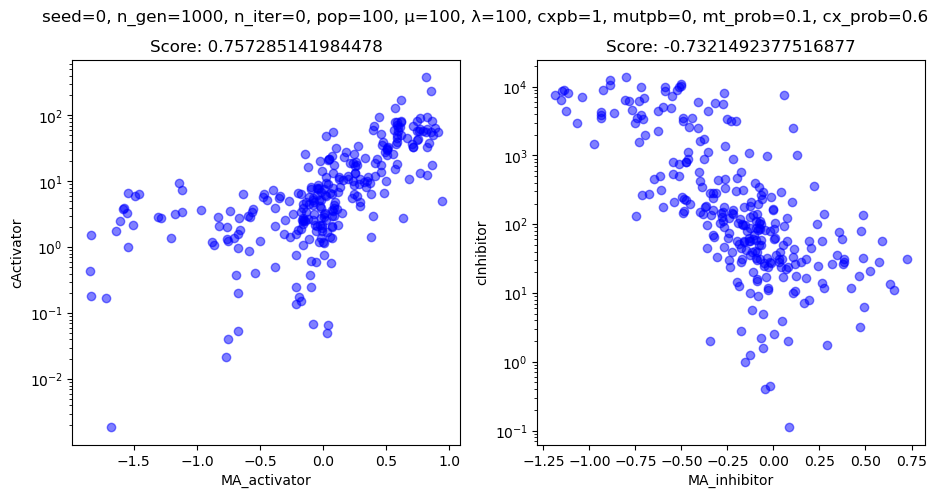

In [160]:
scatter_individual(ind_one=pop[total_sort[-1]])

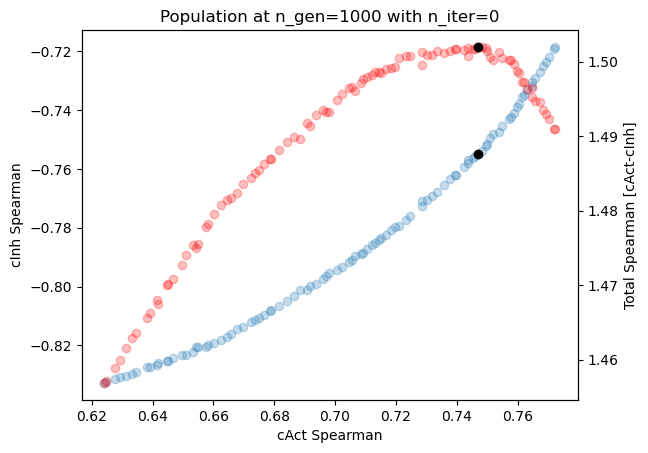

In [97]:
# Plot the final population and their total score
a, b = zip(*[pop[i].fitness.values for i in range(len(pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(a, total_score, alpha=0.25, c='r')
ax1.set_title('Population at n_gen='+str(n_gen)+' with n_iter='+str(n_iter))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(a[total_sort[-1]], b[total_sort[-1]], c='k')
ax2.scatter(a[total_sort[-1]], total_score[total_sort[-1]], c='k')

Text(0, 0.5, 'Total Spearman [cAct-cInh]')

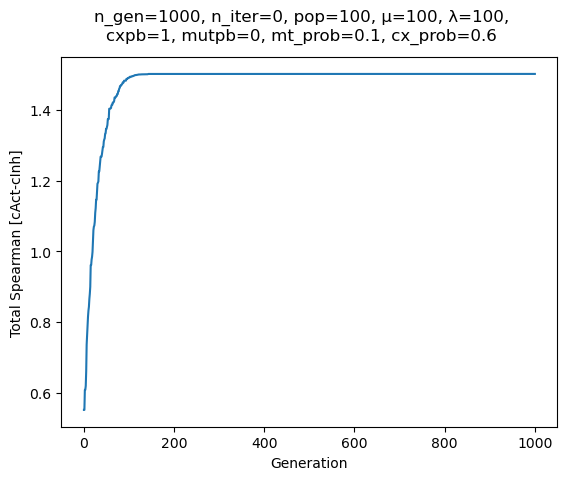

In [98]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, n_gen, n_gen+1)
gen_score = []

for gen_dict in logbook:
    gen_score.append(gen_dict['best'])

fig, ax = plt.subplots()
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+',\ncxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax.plot(gen[:], gen_score[:])
ax.set_xlabel('Generation')
ax.set_ylabel('Total Spearman [cAct-cInh]')

## Going through the NSGA-II algorithm

In [ ]:
pareto_fronts = tools.sortLogNondominated(pop, 100)
for front in pareto_fronts:
    tools.emo.assignCrowdingDist(front)

pop[total_sort[-1]].fitness.crowding_dist

## "Greedy Offspring"

In [249]:
# SECOND DRAFT
# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list
def create_greedy_offspring(base_individual: object,
                            n_iterations: int,
                            grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_iterations: How many random copies should be created
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)

    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.Series(index = grid.index, dtype = 'Int64')

    for i, (ind_act, ind_inh) in enumerate(base_individual):
        # Iterate through the grid parameters for each condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]):
            if (ind_act, ind_inh) == (grid_act, grid_inh):
                position[i] = ii

    # Record the number of steps needed for each condition at each iteration
    steps = pd.DataFrame(index=grid.index, columns=range(n_iterations))

    # Shuffle the order of the conditions and run it many times
    for i in range(n_iterations):
        # Copy the grid and position series and shuffle them
        temp_grid = grid.sample(frac=1, replace=False, random_state=i)
        temp_position = position.reindex(temp_grid.index)

        # Create the iteration's temporary individual
        base_score = np.subtract(base_individual.fitness.values[0], base_individual.fitness.values[1])
        temp_individual = toolbox.clone(base_individual)

        # Baseline
        old_l_score = base_score
        old_r_score = base_score

        # Loop over the shuffled conditions
        for cond in temp_grid.index:
            # Create the condition's temporary individuals
            l_individual = toolbox.clone(temp_individual)
            r_individual = toolbox.clone(temp_individual)

            # Identify where in the individual the condition's parameters are
            cond_loc = grid.index.get_loc(cond)

            # Determine where in the grid the condition's parameters are
            l_position = int(temp_position[cond]-1)
            r_position = int(temp_position[cond]+1)

            # Search the "left" side
            while l_position > -1:
                # Modify the individual, evaluate, and score
                l_individual[cond_loc] = temp_grid[cond][l_position]
                l_individual.fitness.values = toolbox.evaluate(l_individual)
                new_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_l_score > old_l_score: # Check the next "left" position
                    l_position -= 1
                else: # Roll the individual back one step
                    l_position += 1
                    l_individual[cond_loc] = temp_grid[cond][l_position]
                    l_individual.fitness.values = toolbox.evaluate(l_individual)
                    old_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])
                    break

            # Search the "right" side
            while r_position < len(temp_grid[cond]):
                # Modify the individual, evaluate, and score
                r_individual[cond_loc] = temp_grid[cond][r_position]
                r_individual.fitness.values = toolbox.evaluate(r_individual)
                new_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_r_score > old_r_score: # Check the next "left" position
                    r_position += 1
                else: # Roll the individual back one step
                    r_position -= 1
                    r_individual[cond_loc] = temp_grid[cond][r_position]
                    r_individual.fitness.values = toolbox.evaluate(r_individual)
                    old_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])
                    break

            # Compare r_individual and l_individual, use best
            if old_r_score > old_l_score:
                temp_individual = r_individual
                new_position = r_position
            else:
                temp_individual = l_individual
                new_position = l_position
            temp_individual.fitness.values = toolbox.evaluate(temp_individual)

            # Determine steps from original positions
            steps.loc[cond, i] = abs(temp_position[cond]-new_position)
            
        # Add individual to population
        population.append(temp_individual)
    
    return population, steps

In [250]:
def modified_greedy(base_individual: object,
                    n_iterations: int,
                    grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_iterations: How many random copies should be created
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)

    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.Series(index = grid.index, dtype = 'Int64')

    for i, (ind_act, ind_inh) in enumerate(base_individual):
        # Iterate through the grid parameters for each condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]):
            if (ind_act, ind_inh) == (grid_act, grid_inh):
                position[i] = ii

    # Record the number of steps needed for each condition at each iteration
    steps = pd.DataFrame(index=grid.index, columns=range(n_iterations))
    max_steps = 30

    # Shuffle the order of the conditions and run it many times
    for i in range(n_iterations):
        # Create the iteration's temporary individual
        base_score = np.subtract(base_individual.fitness.values[0], base_individual.fitness.values[1])
        temp_individual = toolbox.clone(base_individual)

        # Baseline score
        old_l_score = base_score
        old_r_score = base_score

        # Create a copy of the grid and position series as new objects
        temp_position = position.copy(deep=True)

        for ii in range(100):
            # Copy the grid and position series and shuffle them
            temp_grid = grid.sample(frac=1, replace=False, random_state=i+ii) # What's the best way to set the random state?

            # Loop over the shuffled conditions
            for cond in temp_grid.index:
                # Create the condition's temporary individuals
                l_individual = toolbox.clone(temp_individual)
                r_individual = toolbox.clone(temp_individual)

                # Identify where in the individual the condition's parameters are
                cond_loc = int(grid.index.get_loc(cond))

                if int(temp_position.loc[cond]) == 0:
                    l_position = 0
                else:
                    l_position = int(temp_position.loc[cond]-1)
                    l_steps = 1

                    # Search the "left" side
                    while l_position > -1:
                    # Modify the individual, evaluate, and score
                        l_individual[cond_loc] = temp_grid.loc[cond][l_position]
                        l_individual.fitness.values = toolbox.evaluate(l_individual)
                        new_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])

                        # Compare the score against the best individual
                        if new_l_score > old_l_score:
                            # Continue if not at the end of the grid
                            if l_position == 0 or l_steps == max_steps:
                                old_l_score = new_l_score
                                break
                            else:
                                l_position -= 1
                                l_steps += 1
                        else: # Roll the individual back one step
                            l_position += 1
                            #print(i, ii, cond, l_position, len(temp_grid.loc[cond]))
                            l_individual[cond_loc] = temp_grid.loc[cond][l_position]
                            l_individual.fitness.values = toolbox.evaluate(l_individual)
                            old_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])
                            break

                if int(temp_position.loc[cond])+1 == len(temp_grid.loc[cond]):
                    # This if statement is needed to prevent it from adding one, realizing it is out of bounds, performing better than the left side, and updating to a grid location that is out of bounds
                    r_position = int(temp_position.loc[cond])
                else:
                    r_position = int(temp_position.loc[cond]+1)
                    r_steps = 1
                    
                    # Search the "right" side
                    while r_position < len(temp_grid.loc[cond]):
                        # Modify the individual, evaluate, and score
                        r_individual[cond_loc] = temp_grid.loc[cond][r_position]
                        r_individual.fitness.values = toolbox.evaluate(r_individual)
                        new_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])

                        # Compare the score against the best individual
                        if new_r_score > old_r_score:
                            # Continue if not at the end of the grid
                            if r_position+1 == len(temp_grid.loc[cond]) or r_steps == max_steps:
                                old_r_score = new_r_score
                                break
                            else:
                                r_position += 1
                                r_steps += 1
                        else: # Roll the individual back one step
                            r_position -= 1
                            r_individual[cond_loc] = temp_grid.loc[cond][r_position]
                            r_individual.fitness.values = toolbox.evaluate(r_individual)
                            old_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])
                            break

                # Compare r_individual and l_individual, use best, update the positions for the next round
                if old_r_score > old_l_score:
                    temp_individual = r_individual
                    temp_position.loc[cond] = r_position
                else:
                    temp_individual = l_individual
                    temp_position.loc[cond] = l_position
                temp_individual.fitness.values = toolbox.evaluate(temp_individual)
            
        # Add individual to population
        population.append(temp_individual)
    
    return population

In [101]:
np.subtract(pop[total_sort[-1]].fitness.values[0],pop[total_sort[-1]].fitness.values[1])

1.5019762660346618

In [169]:
n_iter = 1
test_greedy_pop = modified_greedy(pop[total_sort[-1]], n_iter, grid.grid)
greedy_score, greedy_sort = best_individual(test_greedy_pop)

In [103]:
np.subtract(test_greedy_pop[greedy_sort[-1]].fitness.values[0],test_greedy_pop[greedy_sort[-1]].fitness.values[1])

1.8512736693564995

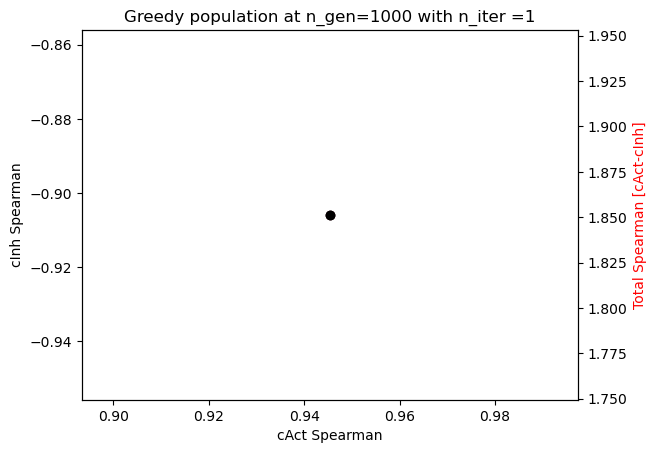

In [104]:
# Plot the final population and their total score
a, b = zip(*[test_greedy_pop[i].fitness.values for i in range(len(test_greedy_pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(a, greedy_score, alpha=0.25, c='r')
ax1.set_title('Greedy population at n_gen='+str(n_gen)+' with n_iter ='+str(n_iter))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]', c='r')
ax1.scatter(a[greedy_sort[-1]], b[greedy_sort[-1]], c='k')
ax2.scatter(a[greedy_sort[-1]], greedy_score[greedy_sort[-1]], c='k')

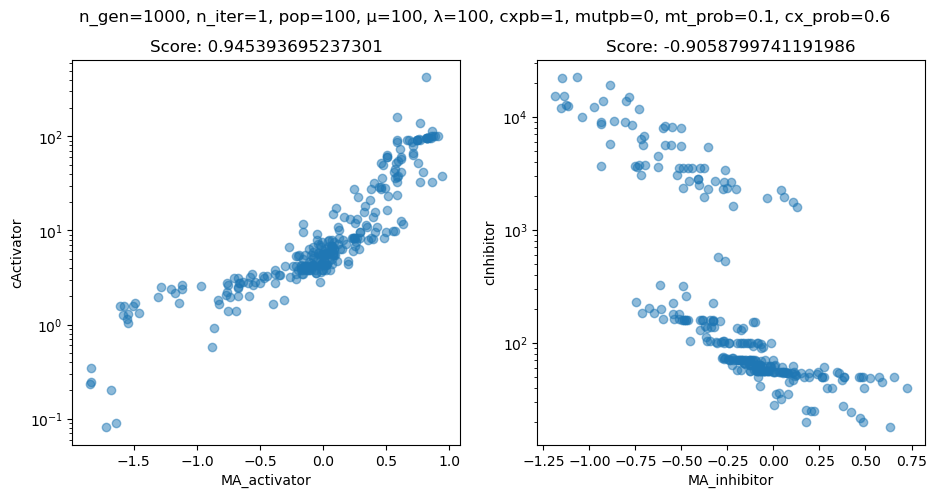

In [105]:
plot_individual = test_greedy_pop[greedy_sort[-1]]
red_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title('Score: '+str(plot_individual.fitness.values[0]))
ax2.set_title('Score: '+str(plot_individual.fitness.values[1]))
#ax1.set_title('Score: '+str(red_individual.fitness.values[0]))
#ax2.set_title('Score: '+str(red_individual.fitness.values[1]))


ax1.scatter(MA_df.iloc[:,0], list(plot_individual['act']), alpha=0.5)
ax2.scatter(MA_df.iloc[:,1], list(plot_individual['inh']), alpha=0.5)
#ax1.scatter(MA_df.iloc[:,0], red_individual[:,0], alpha=0.25, c='r')
#ax2.scatter(MA_df.iloc[:,1], red_individual[:,1], alpha=0.25, c='r')
    

In [182]:
pd.Series(index=grid.index, data=list(test_greedy_pop[greedy_sort[-1]]))

control__wt_glc__1              [4.639009206117262, 44.668359215096345]
control__wt_glc__2               [5.495408738576246, 46.68328030774412]
fur__wt_dpd__1                 [1.9054607179632472, 117.91493904733316]
fur__wt_dpd__2                  [2.290867652767773, 140.96650248308782]
fur__wt_fe__1                   [4.570881896148751, 60.782929495933296]
                                                 ...                   
efeU__menFentCubiC_ale36__2    [4.3462716960282535, 44.668359215096345]
efeU__menFentCubiC_ale37__1      [3.721561939539584, 50.11872336272725]
efeU__menFentCubiC_ale37__2     [3.630780547701014, 51.300804645034304]
efeU__menFentCubiC_ale38__1                  [10.0, 127.78506418403077]
efeU__menFentCubiC_ale38__2    [16.595869074375607, 227.78202252141259]
Length: 274, dtype: object

### Voting

In [135]:
def voting(population: list, grid: pd.Series):
    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.DataFrame(index=grid.index, columns=range(len(population)), dtype='Int64')

    for i, ind in enumerate(population):
        for ii, (ind_act, ind_inh) in enumerate(ind):
            # Iterate through the grid parameters for each condition
            for iii, (grid_act, grid_inh) in enumerate(grid[ii]):
                if (ind_act, ind_inh) == (grid_act, grid_inh):
                    position.iloc[ii, i] = iii

    position['rounded_mean'] = position.mean(axis=1).round()
    position['variance'] = position.var(axis=1)
    position['rounded_median'] = position.median(axis=1).round()
    
    return position

In [136]:
test_voting = voting(pop, grid.grid)
test_voting

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,rounded_mean,variance,rounded_median
control__wt_glc__1,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76.0,0.000000,76.0
control__wt_glc__2,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48.0,0.000000,48.0
fur__wt_dpd__1,73,73,73,73,73,73,73,73,73,73,...,73,73,73,73,73,73,73,73.0,0.000000,73.0
fur__wt_dpd__2,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72.0,0.000000,72.0
fur__wt_fe__1,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137.0,0.000000,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
efeU__menFentCubiC_ale36__2,22,146,146,146,146,22,22,22,22,22,...,22,22,22,22,22,22,22,44.0,2251.911085,22.0
efeU__menFentCubiC_ale37__1,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24.0,0.000000,24.0
efeU__menFentCubiC_ale37__2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46.0,0.000000,46.0
efeU__menFentCubiC_ale38__1,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137.0,0.000000,137.0


In [126]:
mean_individual = creator.individual(pop[total_sort[-1]])
median_individual = creator.individual(pop[total_sort[-1]])

for i, _ in enumerate(mean_individual):
    mean_individual[i] = grid.grid[i][int(test_voting['rounded_mean'][i])]
    median_individual[i] = grid.grid[i][int(test_voting['rounded_median'][i])]

mean_individual.fitness.values = toolbox.evaluate(mean_individual)
print(np.subtract(mean_individual.fitness.values[0], mean_individual.fitness.values[1]))

median_individual.fitness.values = toolbox.evaluate(median_individual)
print(np.subtract(median_individual.fitness.values[0], median_individual.fitness.values[1]))

1.529744758350715
1.4993327581312121


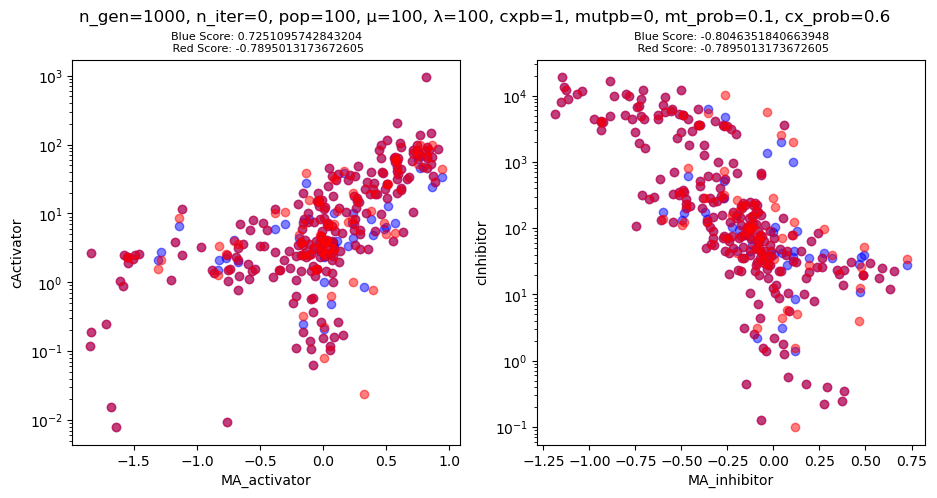

In [155]:
scatter_individual(mean_individual, median_individual)

## How consistent are the final values across different GA runs?

In [164]:
# Set reproducible random seed
seed = 0
rng = np.random.default_rng(seed=seed)

nind = 100
mu = 100
lambda_ = 100
cxpb = 1
mutpb = 0
n_gen = 1000
n_iter = 0

pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=True)

gen	nevals	best    
0  	100   	0.486676
1  	100   	0.486676
2  	100   	0.486676
3  	100   	0.523089
4  	100   	0.582065
5  	100   	0.592511
6  	100   	0.606793
7  	100   	0.674944
8  	100   	0.701988
9  	100   	0.789298
10 	100   	0.789298
11 	100   	0.789298
12 	100   	0.863583
13 	100   	0.863583
14 	100   	0.88621 
15 	100   	0.925047
16 	100   	0.932685
17 	100   	0.96193 
18 	100   	0.993585
19 	100   	0.998286
20 	100   	1.00879 
21 	100   	1.03754 
22 	100   	1.04283 
23 	100   	1.05529 
24 	100   	1.06919 
25 	100   	1.10258 
26 	100   	1.11208 
27 	100   	1.13195 
28 	100   	1.15332 
29 	100   	1.17511 
30 	100   	1.17511 
31 	100   	1.20653 
32 	100   	1.20653 
33 	100   	1.21389 
34 	100   	1.21535 
35 	100   	1.2253  
36 	100   	1.2417  
37 	100   	1.25207 
38 	100   	1.25665 
39 	100   	1.27718 
40 	100   	1.29873 
41 	100   	1.29873 
42 	100   	1.31155 
43 	100   	1.31222 
44 	100   	1.3214  
45 	100   	1.3214  
46 	100   	1.32625 
47 	100   	1.33584 
48 	100   	1.34186 


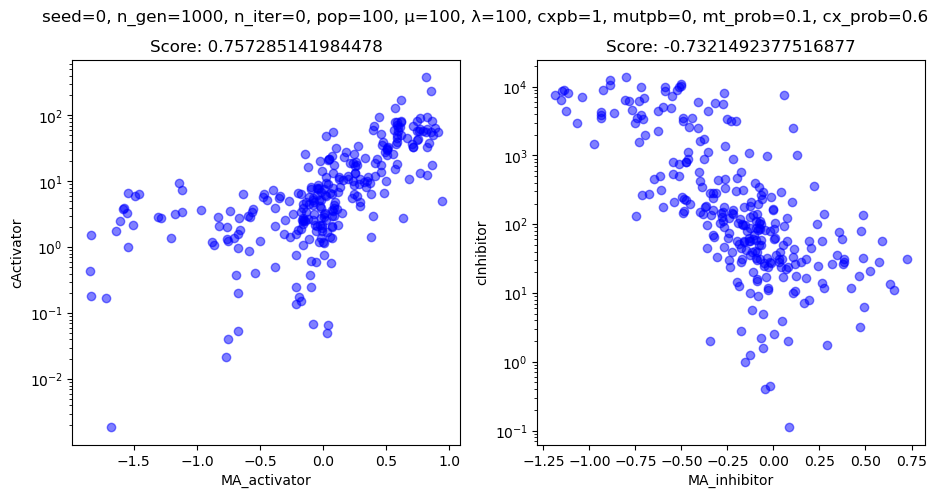

In [165]:
scatter_individual(ind_one=pop[total_sort[-1]])

In [166]:
voting_df = voting(pop, grid.grid)
voting_df

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,rounded_mean,variance,rounded_median
control__wt_glc__1,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76.0,0.000000,76.0
control__wt_glc__2,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48.0,0.000000,48.0
fur__wt_dpd__1,73,73,73,73,73,73,73,73,73,73,...,73,73,73,73,73,73,73,73.0,0.000000,73.0
fur__wt_dpd__2,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72.0,0.000000,72.0
fur__wt_fe__1,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137.0,0.000000,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
efeU__menFentCubiC_ale36__2,22,146,146,146,146,22,22,22,22,22,...,22,22,22,22,22,22,22,44.0,2251.911085,22.0
efeU__menFentCubiC_ale37__1,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24.0,0.000000,24.0
efeU__menFentCubiC_ale37__2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46.0,0.000000,46.0
efeU__menFentCubiC_ale38__1,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137.0,0.000000,137.0


In [188]:
nind = 100
mu = 100
lambda_ = 100
cxpb = 0.6
mutpb = 0.4
n_gen = 1000
n_iter = 0

path = r'/Users/gchhughes/Dropbox (UCSD SBRG)/gchughes@ucsd.edu’s files/regulonML_GA_consistency/' # NOTE: Update depending on which computer I am using

for seed in range(0,1):
    rng = np.random.default_rng(seed=seed)

    pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=False)

    # Use the best individual to create 10 greedy individuals ~50 seconds per individual
    _, total_sort = best_individual(pop)
    greedy_pop = modified_greedy(pop[total_sort[-1]], 10, grid.grid)

    filename = r'__seed_'+str(seed)+'__gen_'+str(n_gen)+'__pop_'+str(nind)+'__mu_'+str(mu)+'__lambda_'+str(lambda_)+'__cxind_'+str(cxpb)+'__cxgene_'+str(cx_prob)+'__mtind_'+str(mutpb)+'__mtgene_'+str(mt_prob)+'.pkl'

    with open(file=path+filename, mode='wb') as file:
        pickle.dump(obj=[grid, pop, logbook, greedy_pop], file=file)
    
    print(seed)

0


## Number of Steps Greedy Offspring Take

In [ ]:
steps

In [ ]:
fig, ax = plt.subplots()
ax.hist(steps.median(axis=1), bins = 40)
ax.set_xlim(left=0, right=)
ax.set_xlabel('Median Number of Steps')
ax.set_ylabel('Number of Conditions')
ax.set_title('Median Number of Steps '+str(n_iter)+' Greedy Offspring Take \n Bin Width=2')

### Labeling the Conditions that have a High Median Number of Steps

In [ ]:
# Identify best individual and their corresponding steps
greedy_steps = pd.DataFrame(data = steps.iloc[:,greedy_sort[-1]], dtype='Int64')
greedy_steps.hist()

In [ ]:
greedy_individual = test_greedy_pop[greedy_sort[-1]]
original_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title('Score: '+str(greedy_individual.fitness.values[0]))
ax2.set_title('Score: '+str(greedy_individual.fitness.values[1]))

ax1.scatter(MA_df.iloc[:,0], greedy_individual[:,0], alpha=0.35, c='b')
ax2.scatter(MA_df.iloc[:,1], greedy_individual[:,1], alpha=0.35, c='b')
ax1.scatter(MA_df.iloc[:,0], original_individual[:,0], alpha=0.15, c='r')
ax2.scatter(MA_df.iloc[:,1], original_individual[:,1], alpha=0.15, c='r')

# Label conditions with a high number of steps
label_index = greedy_steps.index[greedy_steps[greedy_sort[-1]] > 150] # Modify cutoff based on histogram
for cond in label_index:
    i = greedy_steps.index.get_loc(cond)
    ax1.text(x=MA_df.iloc[i,0], y=greedy_individual[i,0], s=cond, c='g')
    ax2.text(x=MA_df.iloc[i,1], y=greedy_individual[i,1], s=cond, c='g')
    #ax1.text(x=MA_df.iloc[i,0], y=original_individual[i,0], s=cond, c='k')
    #ax2.text(x=MA_df.iloc[i,1], y=original_individual[i,1], s=cond, c='k')
    ax1.arrow(x=MA_df.iloc[i,0], y=original_individual[i,0], dx=0, dy=(greedy_individual[i,0]-original_individual[i,0]), length_includes_head=True, color='k')
    ax2.arrow(x=MA_df.iloc[i,1], y=original_individual[i,1], dx=0, dy=(greedy_individual[i,1]-original_individual[i,1]), length_includes_head=True, color='k')

# Other Stuff

In [ ]:
# Effect on scores
base_individual = pop[total_sort[-1]]
n_steps = 10
temp_population = create_greedy_offspring(base_individual, n_steps, grid.grid)+pop

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in temp_population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

c, d = zip(*[temp_population[i].fitness.values for i in range(len(temp_population))])
test_total_score = np.subtract(c,d)
test_total_sort = np.argsort(test_total_score)
test_best_location = test_total_sort[-1]
test_best_individual = temp_population[test_best_location]

In [ ]:
# Plot the final population and their total score
fig, ax1 = plt.subplots()
ax1.scatter(c, d, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(c, test_total_score, alpha=0.25, c='r')
ax1.set_title('Greedy Population at ngen='+str(n_gen)+' with steps='+str(n_steps))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(c[test_best_location], d[test_best_location], c='k')
ax2.scatter(c[test_best_location], test_total_score[test_best_location], c='k')

In [ ]:
test_total_score[test_total_sort]

In [ ]:
plot_individual = temp_population[test_total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(n_gen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

In [ ]:
n_steps = 3
step_list = [step for step in range(-n_steps, n_steps+1) if step != 0]
print(step_list)

test_list = [0, 1, 2, 3, 4]
test_position = 3
print(test_list[test_position])

for step in step_list:
    if -1 < test_position+step < len(test_list):
        print(test_list[test_position+step])